In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import json
import joblib
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import datetime, timedelta

In [12]:
nyc_weather = pd.read_csv('/content/drive/MyDrive/Central_Park_Weather.csv')

print(nyc_weather.head())

                     name    datetime  tempmax  tempmin  temp  feelslikemax  \
0  Central Park, New York  2018-10-30     12.9      6.2   9.1          12.9   
1  Central Park, New York  2018-10-31     17.2      7.2  12.5          17.2   
2  Central Park, New York  2018-11-01     20.7     14.3  17.1          20.7   
3  Central Park, New York  2018-11-02     21.6     17.9  19.7          21.6   
4  Central Park, New York  2018-11-03     18.4     10.0  13.5          18.4   

   feelslikemin  feelslike   dew  humidity  ...  solarenergy  uvindex  \
0           2.9        7.3  -0.4      53.5  ...         12.7        6   
1           6.3       12.3   4.7      59.6  ...         11.6        6   
2          14.3       17.1  12.0      72.4  ...         10.3        5   
3          17.9       19.7  16.8      83.3  ...          2.9        1   
4          10.0       13.5   8.0      72.6  ...          7.5        5   

   severerisk              sunrise               sunset  moonphase  \
0         NaN  2

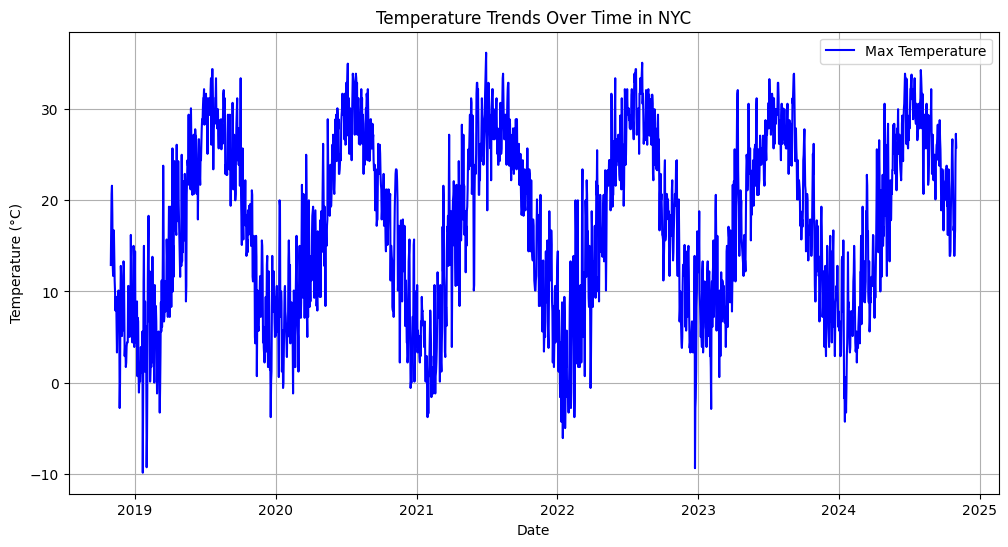

In [13]:
# Line plot for temperature trends over time
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(nyc_weather['datetime']), nyc_weather['tempmax'], label='Max Temperature', color='b')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Trends Over Time in NYC')
plt.legend()
plt.grid(True)
plt.show()

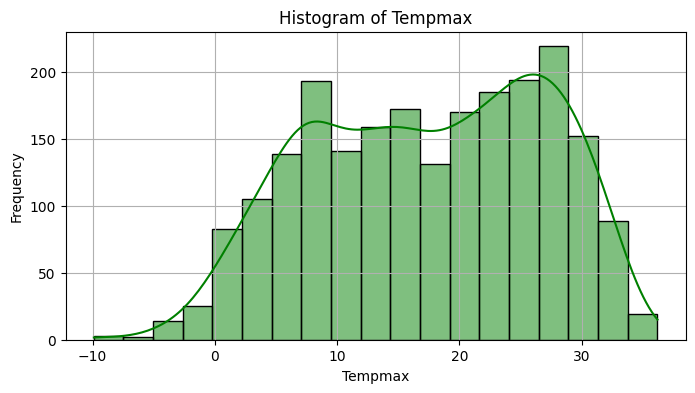

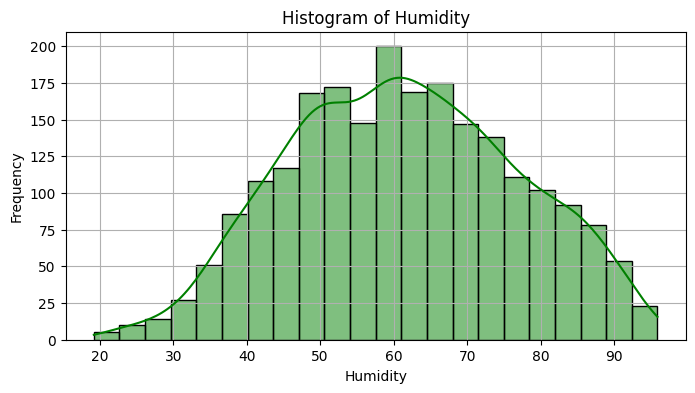

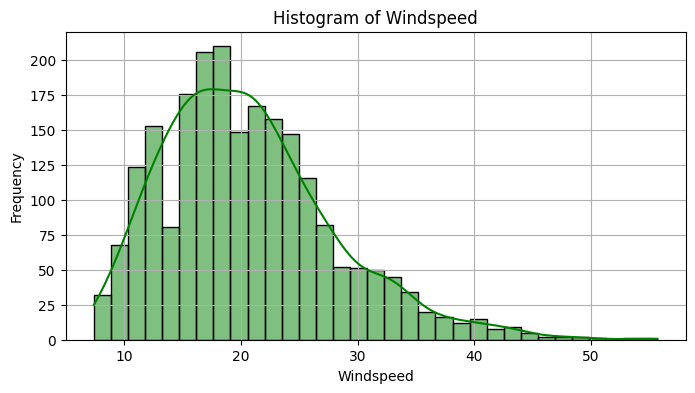

In [14]:
# Histogram of key features (e.g., temperature, humidity, wind speed)
features = ['tempmax', 'humidity', 'windspeed']
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(nyc_weather[feature], kde=True, color='g')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {feature.capitalize()}')
    plt.grid(True)
    plt.show()

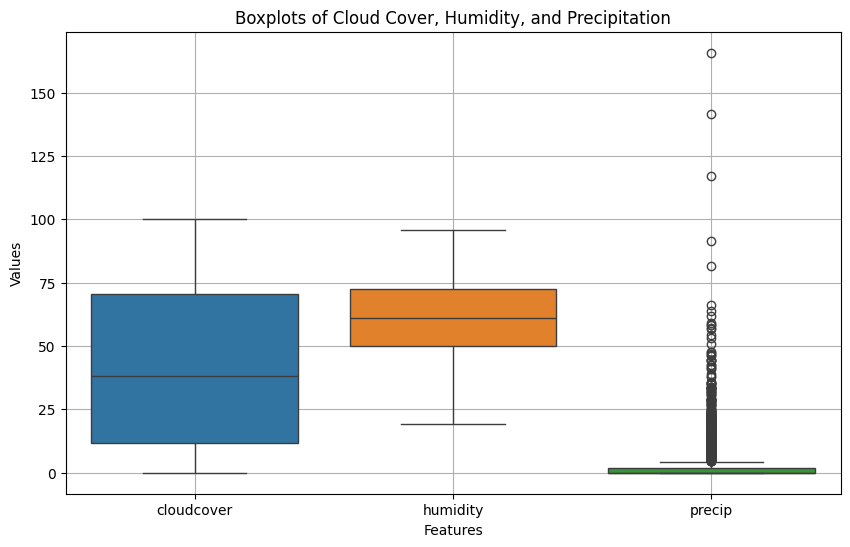

In [15]:
# Boxplots for cloud cover, humidity, and precipitation
plt.figure(figsize=(10, 6))
sns.boxplot(data=nyc_weather[['cloudcover', 'humidity', 'precip']])
plt.title('Boxplots of Cloud Cover, Humidity, and Precipitation')
plt.xlabel('Features')
plt.ylabel('Values')
plt.grid(True)
plt.show()

In [16]:
# Feature Preprocessing
# Convert datetime to datetime format
nyc_weather['datetime'] = pd.to_datetime(nyc_weather['datetime'])

# Drop unnecessary columns
columns_to_drop = ['name', 'stations', 'moonphase', 'description', 'icon', 'severerisk', 'sunrise', 'sunset', 'conditions', 'preciptype']
nyc_weather = nyc_weather.drop(columns=columns_to_drop)

# Handle missing values
nyc_weather = nyc_weather.fillna(method='ffill')

# Feature Engineering
# Daily temperature range
nyc_weather['temp_range'] = nyc_weather['tempmax'] - nyc_weather['tempmin']

# Temperature Change from previous day
nyc_weather['tempmax_change'] = nyc_weather['tempmax'] - nyc_weather['tempmax'].shift(1)
nyc_weather['tempmin_change'] = nyc_weather['tempmin'] - nyc_weather['tempmin'].shift(1)

# Rolling averages
nyc_weather['tempmax_3d_avg'] = nyc_weather['tempmax'].rolling(window=3).mean()
nyc_weather['humidity_3d_avg'] = nyc_weather['humidity'].rolling(window=3).mean()
nyc_weather['windspeed_3d_avg'] = nyc_weather['windspeed'].rolling(window=3).mean()

# Date-based features
nyc_weather['day_of_year'] = nyc_weather['datetime'].dt.dayofyear
nyc_weather['sin_day'] = np.sin(2 * np.pi * nyc_weather['day_of_year'] / 365.25)
nyc_weather['cos_day'] = np.cos(2 * np.pi * nyc_weather['day_of_year'] / 365.25)

# Drop rows with NaN values introduced by lagging or rolling
nyc_weather = nyc_weather.dropna().reset_index(drop=True)

columns_to_drop = ['feelslikemax', 'feelslikemin', 'feelslike', 'temp', 'tempmin']
nyc_weather = nyc_weather.drop(columns=columns_to_drop)

print(nyc_weather.head())

    datetime  tempmax   dew  humidity  precip  precipprob  precipcover  snow  \
0 2018-11-01     20.7  12.0      72.4   0.000           0         0.00   0.0   
1 2018-11-02     21.6  16.8      83.3   5.530         100        16.67   0.0   
2 2018-11-03     18.4   8.0      72.6   9.465         100        33.33   0.0   
3 2018-11-04     12.9   0.7      56.2   0.000           0         0.00   0.0   
4 2018-11-05     11.7   7.7      84.1   7.195         100        50.00   0.0   

   snowdepth  windgust  ...  uvindex  temp_range  tempmax_change  \
0        0.0      29.5  ...        5         6.4             3.5   
1        0.0      55.1  ...        1         3.7             0.9   
2        0.0      76.0  ...        5         8.4            -3.2   
3        0.0      38.9  ...        6         6.7            -5.5   
4        0.0      47.8  ...        1         2.4            -1.2   

   tempmin_change  tempmax_3d_avg  humidity_3d_avg  windspeed_3d_avg  \
0             7.1       16.933333     

<ipython-input-16-7fa67608c02e>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nyc_weather = nyc_weather.fillna(method='ffill')


In [17]:
# Define target and features for the model
X = nyc_weather.drop(columns=['datetime', 'tempmax'])  # Features excluding datetime and target column
y = nyc_weather['tempmax']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Train your linear regression model
LRmodel = LinearRegression()
LRmodel.fit(X_train, y_train)

# Make predictions using the test set
y_pred_lr = LRmodel.predict(X_test)

# Evaluate the model performance
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - Mean Squared Error: {mse_lr}")
print(f"Linear Regression - R-squared: {r2_lr}")

# Save the model to a file named 'linear_regression_model.pkl'
joblib.dump(LRmodel, 'linear_regression_model.pkl')
print("Linear regression model saved successfully.")

Linear Regression - Mean Squared Error: 0.3465134335911787
Linear Regression - R-squared: 0.9962379236743456
Linear regression model saved successfully.


In [19]:
# Train the RandomForest model
RFmodel = RandomForestRegressor(n_estimators=100, random_state=42)
RFmodel.fit(X_train, y_train)

# Make predictions using the test set
y_pred_rf = RFmodel.predict(X_test)

# Evaluate the model performance
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - Mean Absoluted Error: {mae_rf}")
print(f"Random Forest - R-squared: {r2_rf}")

# Save the RandomForest model to a file named 'random_forest_model.pkl'
joblib.dump(RFmodel, 'random_forest_model.pkl')
print("RandomForest model saved successfully.")

Random Forest - Mean Squared Error: 1.7645513576309821
Random Forest - Mean Absoluted Error: 0.980683371298406
Random Forest - R-squared: 0.9808423678725917
RandomForest model saved successfully.


In [20]:
# Get feature importance
importance = RFmodel.feature_importances_

# Create a DataFrame for better visualization
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

             Feature  Importance
19    tempmax_3d_avg    0.898758
17    tempmax_change    0.056737
0                dew    0.020986
16        temp_range    0.005522
18    tempmin_change    0.004641
1           humidity    0.001303
10  sealevelpressure    0.001224
21  windspeed_3d_avg    0.001154
9            winddir    0.001030
11        cloudcover    0.001013
20   humidity_3d_avg    0.000962
7           windgust    0.000863
22       day_of_year    0.000802
8          windspeed    0.000773
24           cos_day    0.000704
23           sin_day    0.000680
14       solarenergy    0.000557
13    solarradiation    0.000518
12        visibility    0.000459
15           uvindex    0.000301
5               snow    0.000258
6          snowdepth    0.000251
2             precip    0.000242
4        precipcover    0.000226
3         precipprob    0.000037


In [21]:
correlation = nyc_weather[['tempmax', 'tempmax_3d_avg']].corr()
print(correlation)

                 tempmax  tempmax_3d_avg
tempmax         1.000000        0.951765
tempmax_3d_avg  0.951765        1.000000


In [22]:
# Train the Gradient Boosting Regressor model
GBmodel = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
GBmodel.fit(X_train, y_train)

# Make predictions using the test set
y_pred_gb = GBmodel.predict(X_test)

# Evaluate the model performance
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting - Mean Squared Error: {mse_gb}")
print(f"Gradient Boosting - R-squared: {r2_gb}")

# Save the RandomForest model to a file named 'random_forest_model.pkl'
joblib.dump(GBmodel, 'gradient_boosting_model.pkl')
print("GradientBoosting model saved successfully.")

Gradient Boosting - Mean Squared Error: 1.0547909680611989
Gradient Boosting - R-squared: 0.9885481954095352
GradientBoosting model saved successfully.


In [23]:
# Get feature importance
importance = GBmodel.feature_importances_

# Create a DataFrame for better visualization
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

             Feature  Importance
19    tempmax_3d_avg    0.844056
0                dew    0.076607
17    tempmax_change    0.043315
16        temp_range    0.018788
18    tempmin_change    0.006691
13    solarradiation    0.002936
11        cloudcover    0.002158
14       solarenergy    0.001282
1           humidity    0.001245
5               snow    0.000740
9            winddir    0.000480
6          snowdepth    0.000397
21  windspeed_3d_avg    0.000320
10  sealevelpressure    0.000235
20   humidity_3d_avg    0.000194
7           windgust    0.000164
15           uvindex    0.000154
8          windspeed    0.000069
12        visibility    0.000049
23           sin_day    0.000045
24           cos_day    0.000039
22       day_of_year    0.000017
4        precipcover    0.000010
2             precip    0.000008
3         precipprob    0.000000


In [15]:
from google.colab import files

# Download the file
files.download('gradient_boosting_model.pkl')
files.download('random_forest_model.pkl')
files.download('linear_regression_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

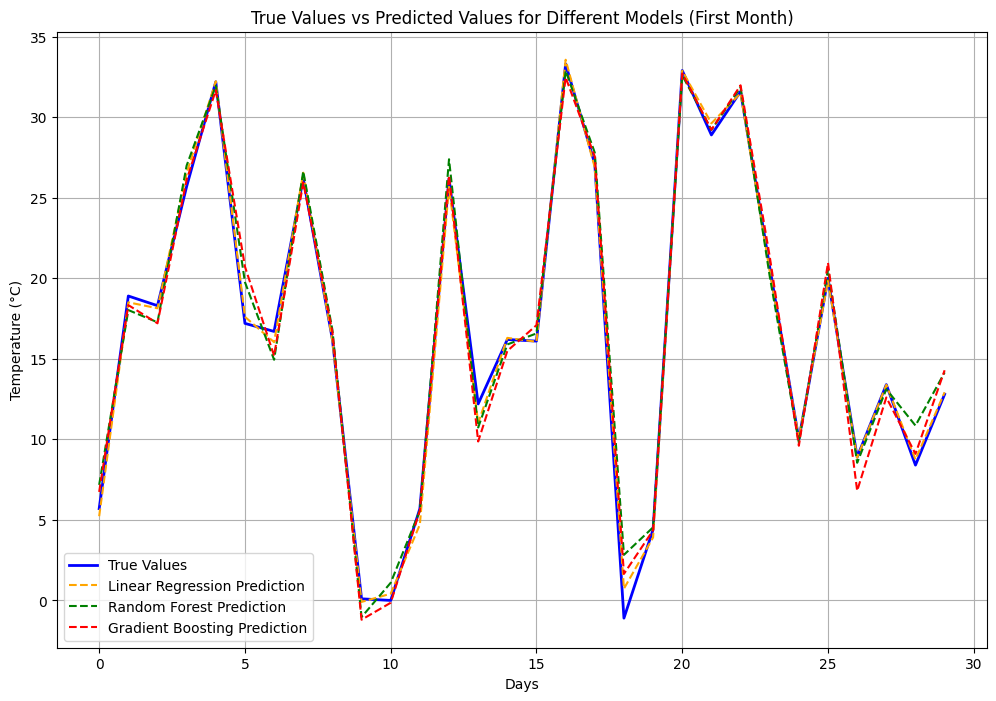

In [24]:
# Plotting the true values vs predicted values for the first month
plt.figure(figsize=(12, 8))

# Select the first 30 values for plotting
n_days = 30

# Plot the true values
plt.plot(y_test.reset_index(drop=True)[:n_days], label='True Values', color='blue', linewidth=2)

# Plot predictions from Linear Regression
plt.plot(y_pred_lr[:n_days], label='Linear Regression Prediction', color='orange', linestyle='--')

# Plot predictions from Random Forest
plt.plot(y_pred_rf[:n_days], label='Random Forest Prediction', color='green', linestyle='--')

# Plot predictions from Gradient Boosting
plt.plot(y_pred_gb[:n_days], label='Gradient Boosting Prediction', color='red', linestyle='--')

# Adding labels and legend
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.title('True Values vs Predicted Values for Different Models (First Month)')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Configuration
API_KEY = "JGT7BGCB9PG84US59NMH2H8X8"
BASE_URL = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/"
LOCATION = "Central Park, New York"

def fetch_weather_data(api_key, location, start_date, end_date):
    """
    Fetch weather data from Visual Crossing API.
    """
    api_url = f"{BASE_URL}{location}/{start_date}/{end_date}?unitGroup=metric&include=days&key={api_key}&contentType=json"
    print(api_url)
    response = requests.get(api_url)

    if response.status_code == 200:
        weather_data = response.json()
        return pd.DataFrame(weather_data['days'])
    else:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")

def add_engineered_features(data):
    """
    Add engineered features to the weather data.
    """
    # Ensure datetime is in datetime format
    data['datetime'] = pd.to_datetime(data['datetime'])

    # Calculate engineered features
    data['temp_range'] = data['tempmax'] - data['tempmin']
    data['tempmax_change'] = data['tempmax'].diff()
    data['tempmin_change'] = data['tempmin'].diff()
    data['tempmax_3d_avg'] = data['tempmax'].rolling(window=3).mean()
    data['humidity_3d_avg'] = data['humidity'].rolling(window=3).mean()
    data['windspeed_3d_avg'] = data['windspeed'].rolling(window=3).mean()
    return data

def extract_features_for_prediction(current_day):
    """
    Extract features from the most recent day's weather data.
    """
    current_day_datetime = pd.to_datetime(current_day['datetime'])
    features = {
        'dew': current_day['dew'],
        'humidity': current_day['humidity'],
        'precip': current_day['precip'],
        'precipprob': current_day['precipprob'],
        'precipcover': current_day['precipcover'],
        'snow': current_day['snow'],
        'snowdepth': current_day['snowdepth'],
        'windgust': current_day['windgust'],
        'windspeed': current_day['windspeed'],
        'winddir': current_day['winddir'],
        'sealevelpressure': current_day['pressure'],
        'cloudcover': current_day['cloudcover'],
        'visibility': current_day['visibility'],
        'solarradiation': current_day['solarradiation'],
        'solarenergy': current_day['solarenergy'],
        'uvindex': current_day['uvindex'],
        'temp_range': current_day['temp_range'],
        'tempmax_change': current_day['tempmax_change'],
        'tempmin_change': current_day['tempmin_change'],
        'tempmax_3d_avg': current_day['tempmax_3d_avg'],
        'humidity_3d_avg': current_day['humidity_3d_avg'],
        'windspeed_3d_avg': current_day['windspeed_3d_avg'],
        'day_of_year': current_day_datetime.dayofyear,
        'sin_day': np.sin(2 * np.pi * current_day_datetime.dayofyear / 365.25),
        'cos_day': np.cos(2 * np.pi * current_day_datetime.dayofyear / 365.25),
    }
    return features

# Main script
if __name__ == "__main__":
    # Define date range
    current_date = (datetime.now() - timedelta(days=0)).strftime('%Y-%m-%d')  # Yesterday as end date
    start_date = (datetime.now() - timedelta(days=5)).strftime('%Y-%m-%d')  # 5 days ago as start date

    # Fetch data
    historical_data = fetch_weather_data(API_KEY, LOCATION, start_date, current_date)

    # Add engineered features
    historical_data = add_engineered_features(historical_data)

    # Extract features for the most recent day
    current_day = historical_data.iloc[-1]
    features = extract_features_for_prediction(current_day)

    # Convert features to DataFrame
    features_df = pd.DataFrame([features])

    # Display results
    print(features_df['dew'].iloc[0])

https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/Central Park, New York/2024-12-04/2024-12-09?unitGroup=metric&include=days&key=JGT7BGCB9PG84US59NMH2H8X8&contentType=json
3.8


In [26]:
# Load the pre-trained models
lr_model = joblib.load('linear_regression_model.pkl')
rf_model = joblib.load('random_forest_model.pkl')
gb_model = joblib.load('gradient_boosting_model.pkl')

# Make the prediction using the loaded model
predicted_tempmax_rf = rf_model.predict(features_df)
predicted_tempmax_lr = lr_model.predict(features_df)
predicted_tempmax_gb = gb_model.predict(features_df)

predicted_tempmax_rf = predicted_tempmax_rf * 9/5 + 32
predicted_tempmax_lr = predicted_tempmax_lr * 9/5 + 32
predicted_tempmax_gb = predicted_tempmax_gb * 9/5 + 32

print(f"RandomForest: Predicted Max Temperature for Tomorrow: {predicted_tempmax_rf[0]:.2f}°F")
print(f"LinearRegression: Predicted Max Temperature for Tomorrow: {predicted_tempmax_lr[0]:.2f}°F")
print(f"GradientBoosting: Predicted Max Temperature for Tomorrow: {predicted_tempmax_gb[0]:.2f}°F")

RandomForest: Predicted Max Temperature for Tomorrow: 48.16°F
LinearRegression: Predicted Max Temperature for Tomorrow: 50.31°F
GradientBoosting: Predicted Max Temperature for Tomorrow: 48.63°F


In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Example historical data (replace this with your actual historical dataset)
# Assuming `nyc_weather` is already prepared as a DataFrame
# X: features, y: target (next day's tempmax)
X = nyc_weather.drop(columns=['datetime', 'tempmax'])
y = nyc_weather['tempmax']

# Normalize the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Reshape features for LSTM: (samples, timesteps, features)
X_lstm = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42)

# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='sigmoid', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for predicting the next day's max temperature

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the LSTM model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)
print(f"LSTM Model - Mean Absolute Error: {mae}")

# Predict based on the current weather data
# Current weather data already prepared in `features_df`
features_scaled = scaler_X.transform(features_df)  # Scale using the same scaler as training
features_reshaped = features_scaled.reshape(1, 1, features_scaled.shape[1])  # Reshape for LSTM

predicted_tempmax_scaled = model.predict(features_reshaped)  # Predict scaled value
predicted_tempmax = scaler_y.inverse_transform(predicted_tempmax_scaled)  # Convert back to original scale

# Convert Celsius to Fahrenheit
predicted_tempmax_f = predicted_tempmax[0][0] * 9/5 + 32
print(f"LSTM: Predicted Max Temperature for Tomorrow: {predicted_tempmax_f:.2f}°F")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2255 - mae: 0.3880 - val_loss: 0.0414 - val_mae: 0.1769
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0885 - mae: 0.2379 - val_loss: 0.0385 - val_mae: 0.1705
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0720 - mae: 0.2155 - val_loss: 0.0338 - val_mae: 0.1583
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0664 - mae: 0.2048 - val_loss: 0.0297 - val_mae: 0.1484
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0553 - mae: 0.1899 - val_loss: 0.0255 - val_mae: 0.1373
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0504 - mae: 0.1804 - val_loss: 0.0208 - val_mae: 0.1232
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0412 - mae: 0.1606 - val_loss: 0.0160 - val_mae: 0.1065
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0334 - mae: 0.1453 - val_loss: 0.0119 - val_mae: 0.0894
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0281 - mae: 0.1340 - 

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  


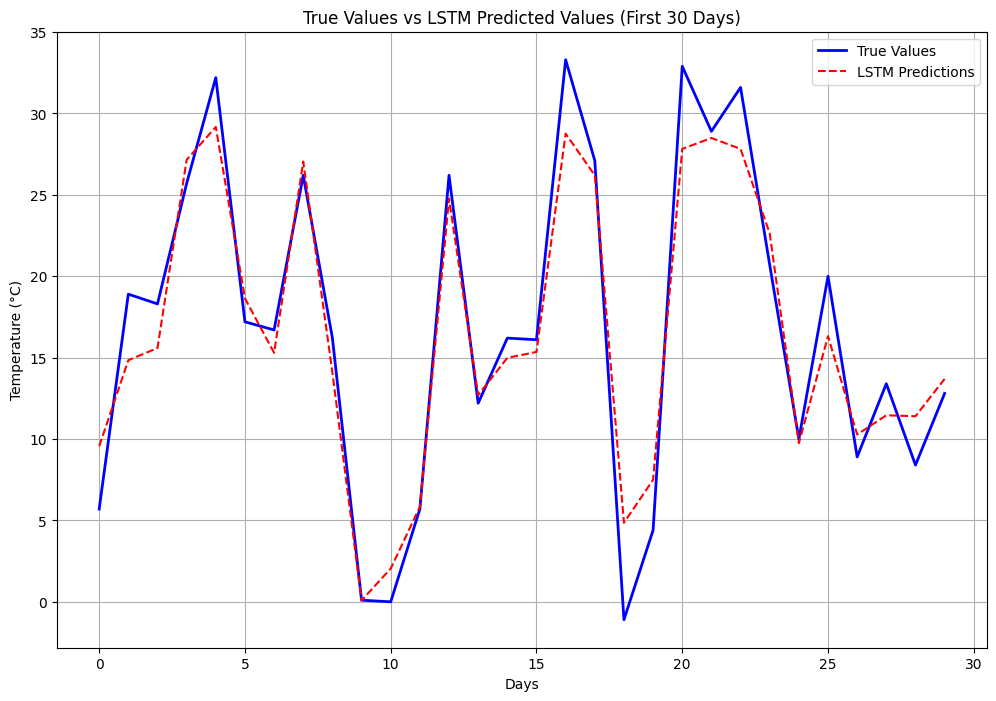

In [31]:
# Predict values for the entire test set using the LSTM model
y_pred_lstm_scaled = model.predict(X_test)  # Predict scaled values
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled)  # Convert back to original scale
y_test_original = scaler_y.inverse_transform(y_test)  # Convert true values back to original scale

# Plot settings
plt.figure(figsize=(12, 8))
n_days = 30  # Number of days to visualize

# Plot true values
plt.plot(y_test_original[:n_days], label='True Values', color='blue', linewidth=2)

# Plot LSTM predictions
plt.plot(y_pred_lstm[:n_days], label='LSTM Predictions', color='red', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.title('True Values vs LSTM Predicted Values (First 30 Days)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
pip install kalshi_python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 2.6 MB/s eta 0:00:00


In [ ]:
import uuid
import kalshi_python
from kalshi_python.models import *
from pprint import pprint

config = kalshi_python.Configuration()
# Comment the line below to use production
config.host = 'https://trading-api.kalshi.com/trade-api/v2'

# Create an API configuration passing your credentials.
# Use this if you want the kalshi_python sdk to manage the authentication for you.
kalshi_api = kalshi_python.ApiInstance(
    email='_email',
    password='_password',
    configuration=config,
)
# Specify the event ticker
today = datetime.now()
tomorrow = today + timedelta(days=1)
formatted_date = tomorrow.strftime("%y%b%d")
formatted_date = formatted_date.upper()
event_ticker = 'HIGHNYC-' + formatted_date
print(event_ticker)

# Fetch event data
eventResponse = kalshi_api.get_event(event_ticker)
# Extract market tickers from the event data
# Assuming eventResponse.markets is the correct path to access the markets data
market_tickers = [market.ticker for market in eventResponse.markets]

print('\nMarket tickers for the event:')
pprint(market_tickers)

In [ ]:
# Specify the market ticker
extracted_market_tickers = [item.split(event_ticker + '-')[1] for item in market_tickers]
float_market_tickers = [float(value[1:]) for value in extracted_market_tickers]

market_ticker  = ''
for i, value in enumerate(float_market_tickers):
    if i == 0 and value > predicted_tempmax_rf:  # First value
        market_ticker = '-T' + str(int(float_market_tickers[i]))
    elif i == len(float_market_tickers) - 1 and value < predicted_tempmax_rf:  # Last value
        market_ticker = '-T' + str(int(float_market_tickers[len(float_market_tickers) - 1]))
    elif predicted_tempmax_rf - 1.49 <= value <= predicted_tempmax_rf + 1.49:
        market_ticker = '-B' + str(value)  # Middle value
        market_ticker = market_ticker.replace('.0', '.5')
        break

market_ticker = event_ticker + market_ticker
print(market_ticker)

In [ ]:
# Checks if the exchange is available.
exchangeStatus = kalshi_api.get_exchange_status()
if exchangeStatus.trading_active:
    # Generate a unique identifier for the order
    orderUuid = str(uuid.uuid4())
    # Create and submit the order
    orderResponse = kalshi_api.create_order(CreateOrderRequest(
        ticker=market_ticker,
        action='buy',
        type='limit',
        yes_price=50,
        count=20,
        client_order_id=orderUuid,
        side='yes',
    ))
    print('\nOrder submitted: ')
    pprint(orderResponse)
else:
    print('\nThe exchange is not trading active, no orders will be sent right now.')